In [1]:
%load_ext autoreload
%autoreload 2

DATA_DIR = '../data/'

# Explore the columns of data and find outliers
import pandas as pd
import os
import os.path as osp
from typing import Optional
import numpy as np

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('../')

In [2]:
# Visualization libraries
import geopandas as gpd
from source.utils.visualization import *
from source.utils.preprocessing import *
SAVE_EXTENSION = '.pdf'
SAVE_DIR = '../figures/'

plot_kwargs = {
    "column" : "half",
    "nrows" : 1,
    "ncols" : 1,
    "usetex" : False
}

setup_plotting_icml2022(
    **plot_kwargs
    )

# Regional Correlation Visualizations

In [3]:
import pickle
CORRELATION_PICKLE_PATH = osp.join(DATA_DIR,'correlations/correlations_2017_2022_top_200.pickle')
PICKLE_LABEL = '2017_2022_top_200'
assert os.path.exists(CORRELATION_PICKLE_PATH), 'Check the pathing to the correlation pickle file'

# Load the data
with open(CORRELATION_PICKLE_PATH, 'rb') as f:
    df = pickle.load(f)

In [4]:
# This seperation is predefined while saving the pickle
df_corr = {k:v[0] for k,v in df.items()}
df_spearman = {k:v[1] for k,v in df.items()}
df_kendall = {k:v[2] for k,v in df.items()}

In [11]:

def plot_correlation(df : pd.DataFrame, 
                     method : str ="Pearson",
                     show_extremes: bool = True,
                     save_path : Optional[str] = None,
                     show : bool = True,
                     **plot_kwargs
                     ):
    """
    Plots the correlation between popularity and audio features for different regions.

    Parameters:
    - df: DataFrame or Series
        The data containing the correlation values between popularity and audio features for different regions.
    - method: str, optional
        The label for the correlation method. Default is "Pearson".
    - show_extremes: bool, optional
        Whether to annotate the extreme correlation values with the corresponding region. Default is True.
    - save_path: str, optional
        The file path to save the plot. If not provided, the plot will not be saved.
    - **plot_kwargs: keyword arguments
        Additional keyword arguments to customize the plot.

    Returns:
    None
    """
    def _annotate_extremes(df):
        max_values = df.iloc[1:, :].T.idxmax()
        for feature, country in max_values.items():
            max_corr = df.loc[feature, country]
            plt.annotate(country, xy=(feature, max_corr), xytext=(-5, 10), textcoords='offset points')

        min_values = df.iloc[1:, :].T.idxmin()
        for feature, country in min_values.items():
            min_corr = df.loc[feature, country]
            plt.annotate(country, xy=(feature, min_corr), xytext=(-5, -22), textcoords='offset points')

    if isinstance(df, pd.Series):
        df = pd.DataFrame(df)
    
    # Add violin plot for each audio features
    for i, feature in enumerate(df.index[1:]):
        plt.violinplot(dataset=df.loc[feature, :].values[1:], positions=[i], showmeans=True, showextrema=True)


    # for region in df.columns:
    #     corr = df[region]
    #     plt.scatter(x = corr[1:].index, y = corr[1:].values, alpha = 0.5, label = region, marker='o', s=5,
    #                 c = "gray", **plot_kwargs) # Skip because first value is 1.0 always

    if show_extremes:
        _annotate_extremes(df)

    # Set xticks to the audio features
    plt.xticks(range(len(df.index[1:])), [audio_feature_to_label(audio_feature) for audio_feature in df.index[1:]],
               rotation=15
               )
    
    
    # plt.title(f"{method} correlation between popularity and audio features")
    plt.ylabel("Correlation")
    plt.grid(True)
    plt.tight_layout()
    save_plot(save_path)

    # Close the figure so that it does not show up in the notebook
    if not show:
        plt.close()

def save_plot(save_path):
    if save_path is not None:
        plt.savefig(save_path)

def plot_mean_std_correlation(df, save_path=None, legends: Optional[list] = None, show : bool = True):
    if isinstance(df, pd.Series):
        df = pd.DataFrame(df)

    if not isinstance(df, list):
        df = [df]

    for _df in df:
        mean_corr = _df.mean()[1:]
        std_corr = _df.std()[1:]

        plt.errorbar(mean_corr.index, mean_corr.values, yerr=std_corr.values, linestyle='-', marker='o')

        plt.xticks(rotation=45)
        plt.title("Mean and Standard Deviation of Correlations", fontsize=14)
        plt.ylabel("Correlation", fontsize=12)
        plt.xlabel("Audio feature", fontsize=12)
        plt.grid(True)
        plt.tight_layout()

    if legends is not None:
        plt.legend(legends, loc='upper right', fontsize=12)

    save_plot(save_path)
        
    # Close the figure so that it does not show up in the notebook
    if not show:
        plt.close()
    

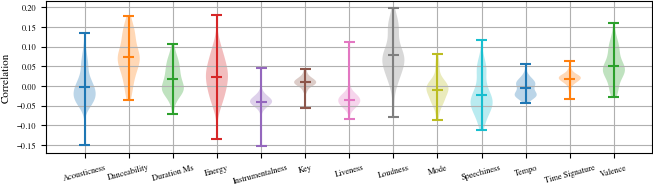

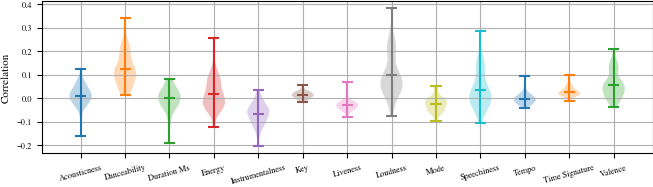

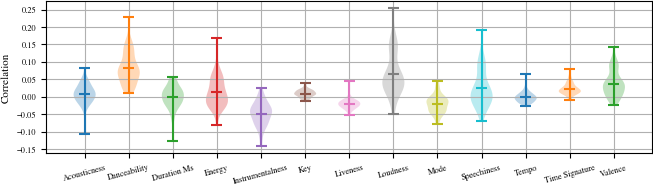

In [12]:

plot_kwargs.update({"column" : "full", "nrows" : 0.5, "ncols" : 1})

# Plot the correlation of all regions
for label, df in zip(["Pearson", "Spearman", "Kendall"], [df_corr, df_spearman, df_kendall]):
    reset_plottings(**plot_kwargs)
    plot_correlation(pd.DataFrame(df), method=label, show_extremes=False, show=True,
                    save_path=osp.join(SAVE_DIR, 'corr_plots', f'correlation_{label.lower()}_{PICKLE_LABEL}{SAVE_EXTENSION}'))
    plt.show()

# # Plot the mean and std of all regions
# plot_mean_std_correlation([pd.DataFrame(df_spearman).T.drop("Global")],
#                           save_path=os.path.join(SAVE_DIR,'corr_plots',f"mean_std_correlation_{PICKLE_LABEL}{SAVE_EXTENSION}"), legends = ["Spearman"])
# reset_plottings(**plot_kwargs)


## Map Visualization


Visualizing everything on maps gives us a better understanding for how regions are correlated within itself.

KeyboardInterrupt: 

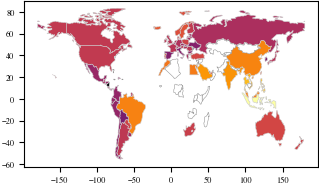

In [9]:
import matplotlib.colors as mcolors

# Update the mapping for specific labels
country_map = {
    "United States" : "United States of America",
    'Dominican Republic': 'Dominican Rep.',
    'Czech Republic': 'Czechia',
    'Hong Kong' : 'China',
}

labels = ["Pearson", "Spearman", "Kendall"]
plot_kwargs.update({"column" : "half", "nrows" : 1, "ncols" : 1})
for df_corr_full,corr_label in zip([pd.DataFrame(df_corr), pd.DataFrame(df_spearman), pd.DataFrame(df_kendall)],labels):
    # Load the world map shapefile
    world_map = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    
    # Merge the world map with your correlation data
    df_corr_full = pd.DataFrame(df_corr_full).T.reset_index().rename(columns={"index":"Country"}).fillna(0)


    df_corr_full['Country'] = df_corr_full['Country'].replace(country_map)

    # Create a mapping for unmatched labels
    unmatched_labels = set(world_map['name']) - set(df_corr_full['Country'])

    # Iterate over each audio feature
    for feature in df_corr_full.columns[2:]:
        reset_plottings(**plot_kwargs)
        
        # Merge the data with the world map
        merged_data = world_map.merge(df_corr_full[['Country', feature]], left_on='name', right_on='Country', how='left')

        # Plot the correlation on the world map
        fig, ax = plt.subplots(1)
        merged_data.plot(column=feature, cmap='inferno', linewidth=0.4, ax=ax, edgecolor='0.8', legend=False)

        # Make each unmatched label white on the map with outlinings
        for label in unmatched_labels:
            merged_data[merged_data['name'] == label].plot(color='white', edgecolor='0.6', linewidth=0.4, ax=ax)

        # Customize the plot
        # ax.set_title(f'{corr_label} correlations between streams and {feature}')
        ax.axis('off')

        sm = plt.cm.ScalarMappable(cmap='inferno', norm=plt.Normalize(vmin=merged_data[feature].min(), vmax=merged_data[feature].max()))
        sm.set_array([])
        fig.colorbar(sm, shrink=0.6, ax=ax)  # Adjust the size by changing the shrink parameter
        
        # Save the figure
        save_path = f'world_map_{corr_label}_{PICKLE_LABEL}_{feature}{SAVE_EXTENSION}'
        plt.savefig(os.path.join(SAVE_DIR,"wmaps",save_path))

        print(f'World map for {feature} saved as {save_path}')


KeyboardInterrupt: 

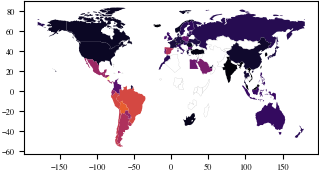

In [10]:
import matplotlib.colors as mcolors

# Update the mapping for specific labels
country_map = {
    "United States" : "United States of America",
    'Dominican Republic': 'Dominican Rep.',
    'Czech Republic': 'Czechia',
    'Hong Kong' : 'China',
}

labels = ["Pearson", "Spearman", "Kendall"]
plot_kwargs.update({"column" : "half", "nrows" : 1, "ncols" : 1})
for df_corr_full,corr_label in zip([pd.DataFrame(df_corr), pd.DataFrame(df_spearman), pd.DataFrame(df_kendall)],labels):
    # Load the world map shapefile
    world_map = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    
    # Merge the world map with your correlation data
    df_corr_full = pd.DataFrame(df_corr_full).T.reset_index().rename(columns={"index":"Country"}).fillna(0)


    df_corr_full['Country'] = df_corr_full['Country'].replace(country_map)

    # Create a mapping for unmatched labels
    unmatched_labels = set(world_map['name']) - set(df_corr_full['Country'])

    # Iterate over each audio feature
    feature = "corr_norm"
    df_corr_full['corr_norm'] = np.linalg.norm(df_corr_full.iloc[:, 2:].values, axis=1)
    
    reset_plottings(**plot_kwargs)
    
    # Merge the data with the world map
    merged_data = world_map.merge(df_corr_full[['Country', feature]], left_on='name', right_on='Country', how='left')

    # Plot the correlation on the world map
    fig, ax = plt.subplots(1)
    merged_data.plot(column=feature, cmap='inferno', linewidth=0, ax=ax, edgecolor='0.8', legend=False)

    # Make each unmatched label white on the map with outlinings
    for label in unmatched_labels:
        merged_data[merged_data['name'] == label].plot(color='white', edgecolor='0.6', linewidth=0.1, ax=ax)

    # Customize the plot
    # ax.set_title(f'{corr_label} correlations between streams and {feature}')
    ax.axis('off')

    sm = plt.cm.ScalarMappable(cmap='inferno', norm=plt.Normalize(vmin=merged_data[feature].min(), vmax=merged_data[feature].max()))
    sm.set_array([])
    fig.colorbar(sm, shrink=0.6, ax=ax)  # Adjust the size by changing the shrink parameter
    
    # Save the figure
    save_path = f'world_map_{corr_label}_{PICKLE_LABEL}_{feature}{SAVE_EXTENSION}'
    plt.savefig(os.path.join(SAVE_DIR,"wmaps",save_path))
    plt.close()



In [16]:
# get number of rows for each country and create a new dataframe
import plotly.express as px
import pycountry

labels = ["Pearson", "Spearman", "Kendall"]
plot_kwargs.update({"column" : "half", "nrows" : 1, "ncols" : 1})
for df_corr_full,corr_label in zip([pd.DataFrame(df_corr), pd.DataFrame(df_spearman), pd.DataFrame(df_kendall)],labels):

    # Merge the world map with your correlation data
    df_corr_full = pd.DataFrame(df_corr_full).T.reset_index().rename(columns={"index":"Country"}).fillna(0)

    # make index a column as well
    df_corr_full.reset_index(inplace=True)

    # get iso codes and add them to the dataframe
    iso_codes = []
    for country in df_corr_full['Country']:
        try:
            iso_codes.append(pycountry.countries.search_fuzzy(country)[0].alpha_3)
        except:
            iso_codes.append('None')
    df_corr_full['iso_code'] = iso_codes
    # Change the iso code position

    df_corr_full.loc[df_corr_full['Country'] == 'Turkey', 'iso_code'] = 'TUR'

    # Add norm
    df_corr_full['corr_norm'] = np.linalg.norm(
        df_corr_full.iloc[:, 3:-1].values,axis=1)
        
    for feature in df_corr_full.columns[3:]:
        if feature  == "iso_code":
            continue
        reset_plottings(**plot_kwargs)
        
        fig = px.choropleth(df_corr_full, 
                            locations='iso_code', 
                            color=feature, 
                            hover_name='Country',
                            projection='natural earth', 
                            color_continuous_scale='ice',
                            )
        
        # Do not display the legend
        fig.update_layout(coloraxis_colorbar=dict(
            title = audio_feature_to_label(feature),
            len=0.75,
            lenmode='fraction',
        ))
        
        # Save the figure
        save_path = f'world_map_{corr_label}_{PICKLE_LABEL}_{feature}.png'
        fig.write_image(os.path.join(SAVE_DIR,"wmaps",save_path))

        # Close the fiugre
        fig.show()



SubdivisionHierarchy(code='GT-GU', country_code='GT', name='Guatemala', parent_code=None, type='Department')
SubdivisionHierarchy(code='BE-WLX', country_code='BE', name='Luxembourg', parent='WAL', parent_code='BE-WAL', type='Province')
SubdivisionHierarchy(code='LU-LU', country_code='LU', name='Luxembourg', parent_code=None, type='Canton')
SubdivisionHierarchy(code='MX-MEX', country_code='MX', name='México', parent_code=None, type='State')
SubdivisionHierarchy(code='PA-8', country_code='PA', name='Panamá', parent_code=None, type='Province')


SubdivisionHierarchy(code='GT-GU', country_code='GT', name='Guatemala', parent_code=None, type='Department')
SubdivisionHierarchy(code='BE-WLX', country_code='BE', name='Luxembourg', parent='WAL', parent_code='BE-WAL', type='Province')
SubdivisionHierarchy(code='LU-LU', country_code='LU', name='Luxembourg', parent_code=None, type='Canton')
SubdivisionHierarchy(code='MX-MEX', country_code='MX', name='México', parent_code=None, type='State')
SubdivisionHierarchy(code='PA-8', country_code='PA', name='Panamá', parent_code=None, type='Province')


SubdivisionHierarchy(code='GT-GU', country_code='GT', name='Guatemala', parent_code=None, type='Department')
SubdivisionHierarchy(code='BE-WLX', country_code='BE', name='Luxembourg', parent='WAL', parent_code='BE-WAL', type='Province')
SubdivisionHierarchy(code='LU-LU', country_code='LU', name='Luxembourg', parent_code=None, type='Canton')
SubdivisionHierarchy(code='MX-MEX', country_code='MX', name='México', parent_code=None, type='State')
SubdivisionHierarchy(code='PA-8', country_code='PA', name='Panamá', parent_code=None, type='Province')


### Similarity of Correlations
There seems to be a pattern of correlations as shown in the world-map plots. For example South America seems to have a similar tendencies for listening a song more based on a specific choice of audio feature scores

In [33]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans,DBSCAN, MeanShift, AffinityPropagation

APPLY_DIM_REDUCTION = False
METHOD = "AffinityPropagation"

# Update the mapping for specific labels
country_map = {
    "United States" : "United States of America",
    'Dominican Republic': 'Dominican Rep.',
    'Czech Republic': 'Czechia',
    'Hong Kong' : 'China',
    'Turkey' : 'Türkiye'
}

corr_labels = ["Pearson", "Spearman"]
plot_kwargs.update({"column" : "half", "nrows" : 1, "ncols" : 1})
for df_corr_full,corr_label in zip([pd.DataFrame(df_corr), pd.DataFrame(df_spearman)],corr_labels):

    df_corr_full.drop(columns=['Global'], inplace=True)
    reset_plottings(**plot_kwargs)
    # Merge the world map with your correlation data
    df_corr_full = pd.DataFrame(df_corr).T.reset_index().rename(columns={"index":"Country"}).fillna(0)
    
    # Apply PCA to get the first two principal components
    if APPLY_DIM_REDUCTION:
        pca = PCA(n_components=2)

        # Fit the PCA model to the data
        pca_features = pca.fit_transform(df_corr_full.iloc[:,2:])
        fv = pca_features
    else:
        fv = df_corr_full.iloc[:,2:].values

    # get iso codes and add them to the dataframe
    iso_codes = []
    for country in df_corr_full['Country']:
        try:
            iso_codes.append(pycountry.countries.search_fuzzy(country)[0].alpha_3)
        except:
            iso_codes.append('None')
    
    df_corr_full['iso_code'] = iso_codes
    # Change the iso code position

    df_corr_full.loc[df_corr_full['Country'] == 'Turkey', 'iso_code'] = 'TUR'


    # Cluster the pca_features
    if METHOD == "KMeans":
        kmeans = KMeans(n_clusters=5, random_state=42)
        kmeans.fit(fv)
        df_corr_full['cluster_label'] = kmeans.labels_
    elif METHOD == "AffinityPropagation":
        affinity_propagation = AffinityPropagation(random_state=42)
        affinity_propagation.fit(fv)
        df_corr_full['cluster_label'] = affinity_propagation.labels_
    elif METHOD == "MeanShift":
        mean_shift = MeanShift(max_iter=500)
        mean_shift.fit(fv)
        df_corr_full['cluster_label'] = mean_shift.labels_
        
    # Merge the data with the world map
    merged_data = world_map.merge(df_corr_full[['Country', 'cluster_label']], left_on='name', right_on='Country', how='left')

    # Plot the correlation on the world map
    fig, ax = plt.subplots(1)

    # Remove the all colors without a label on dataset

    # Make each unmatched label white on the map with outlinings
    for label in unmatched_labels:
        merged_data[merged_data['name'] == label].plot(color='white', edgecolor='0.4', linewidth=0.1, ax=ax)

    # Remove the colorbar
    reset_plottings(**plot_kwargs)
    
    fig = px.choropleth(df_corr_full, 
                        locations='iso_code', 
                        color='cluster_label', 
                        hover_name='Country',
                        projection='natural earth', 
                        color_continuous_scale='ice',
                        )
    
    # Do not display the legend
    fig.update_coloraxes(showscale=False) 

    # Save the figure
    save_path = f'world_map_clustering_{corr_label}_{PICKLE_LABEL}{SAVE_EXTENSION}'
    fig.write_image(os.path.join(SAVE_DIR,"wmaps",save_path))

    # Close the fiugre
    fig.show()


SubdivisionHierarchy(code='GT-GU', country_code='GT', name='Guatemala', parent_code=None, type='Department')
SubdivisionHierarchy(code='BE-WLX', country_code='BE', name='Luxembourg', parent='WAL', parent_code='BE-WAL', type='Province')
SubdivisionHierarchy(code='LU-LU', country_code='LU', name='Luxembourg', parent_code=None, type='Canton')
SubdivisionHierarchy(code='MX-MEX', country_code='MX', name='México', parent_code=None, type='State')
SubdivisionHierarchy(code='PA-8', country_code='PA', name='Panamá', parent_code=None, type='Province')


SubdivisionHierarchy(code='GT-GU', country_code='GT', name='Guatemala', parent_code=None, type='Department')
SubdivisionHierarchy(code='BE-WLX', country_code='BE', name='Luxembourg', parent='WAL', parent_code='BE-WAL', type='Province')
SubdivisionHierarchy(code='LU-LU', country_code='LU', name='Luxembourg', parent_code=None, type='Canton')
SubdivisionHierarchy(code='MX-MEX', country_code='MX', name='México', parent_code=None, type='State')
SubdivisionHierarchy(code='PA-8', country_code='PA', name='Panamá', parent_code=None, type='Province')


In [35]:
# Print the countries in each cluster
for label in df_corr_full['cluster_label'].unique():
    countries_label = df_corr_full[df_corr_full['cluster_label'] == label]['Country'].values

    # Print them in a nice way
    iso_3_codes = []
    for country in countries_label:
        try:
            iso_3_codes.append(pycountry.countries.search_fuzzy(country)[0].alpha_3)
        except:
            if country == 'Turkey':
                iso_3_codes.append('TUR')
            else:
                iso_3_codes.append('None')

    print([iso for iso in iso_3_codes if iso != 'None'])



SubdivisionHierarchy(code='GT-GU', country_code='GT', name='Guatemala', parent_code=None, type='Department')
SubdivisionHierarchy(code='MX-MEX', country_code='MX', name='México', parent_code=None, type='State')
SubdivisionHierarchy(code='PA-8', country_code='PA', name='Panamá', parent_code=None, type='Province')
['ARG', 'COL', 'BOL', 'CHL', 'CRI', 'DOM', 'ECU', 'SLV', 'GTM', 'HND', 'MEX', 'PAN', 'PRY', 'PER', 'ESP', 'URY']
['AUS', 'DNK', 'CAN', 'ISL', 'NZL', 'NOR', 'SWE', 'TUR', 'GBR', 'USA', 'ROU', 'ZAF', 'ARE', 'RUS']
['BRA']
['AUT', 'BGR', 'CZE', 'FRA', 'DEU', 'ITA', 'SVK', 'MAR', 'KOR']
SubdivisionHierarchy(code='BE-WLX', country_code='BE', name='Luxembourg', parent='WAL', parent_code='BE-WAL', type='Province')
SubdivisionHierarchy(code='LU-LU', country_code='LU', name='Luxembourg', parent_code=None, type='Canton')
['BEL', 'JPN', 'LUX', 'NLD', 'CHE']
['FIN', 'EST', 'GRC', 'HUN', 'IRL', 'LVA', 'LTU', 'POL', 'PRT', 'EGY', 'ISR', 'SAU', 'UKR']
['HKG', 'MYS', 'SGP', 'TWN', 'THA', 'VNM'

## Conclusion
It seems that many of the countries has weak-moderate correlations in their top-charts. Although this correlation is not strong, this founding shows that audio features do have some effects on different countries and their preferences.